# Population Data from CSV

This notebooks reads sample population data from `data/atlantis.csv` and plots it using Matplotlib. Edit `data/atlantis.csv` and re-run this cell to see how the plots change!

In [150]:
import numpy as np
from keras import layers, models
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

stock_data = yf.Ticker("^GSPC")
data = stock_data.history(period="max").iloc[-100:]

In [151]:
data["Close_next"] = data["Close"].shift(1)
data["Target"] = (data["Close_next"] > data["Close"]).astype(int)
# data = data.iloc[1:]

In [152]:
X_training_size = len(data) // 10
y_training_size = X_training_size
X_train_data = []
y_train_data = []
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for i in range(int(len(data)) - 2*X_training_size):
    X_slice = data.iloc[i:i+X_training_size][["Open", "High", "Low", "Close", "Volume"]].to_numpy()
    y_slice = data.iloc[i+X_training_size:i+X_training_size+y_training_size][["Target"]].to_numpy()
    X_slice_scaled = scaler.fit_transform(X_slice)
    X_train_data.append(X_slice_scaled)
    y_train_data.append(y_slice)

Found existing model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


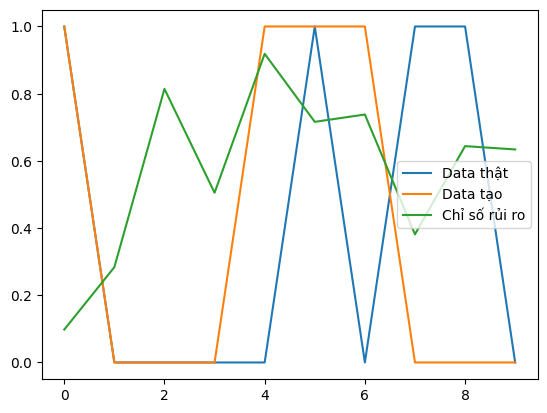

MSE: 0.4
MAE: 0.4
R2: -0.6666666666666665
Train acc: 50.00%
Test acc: 60.00%


In [156]:
import os
from tqdm import tqdm

model = None

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

if os.path.exists("SP500_model.keras"):
    print("Found existing model")
    model = load_model("SP500_model.keras")
else:
    print("Didn't found existing model. Creating a new model.")
    model = models.Sequential([
        layers.Input(shape=(5,)),
        layers.Dense(256, activation='relu', kernel_regularizer='l2'),

        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),

        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),

        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy")

    #Train the model
    length_training = len(X_train_data) - 1

    last_num = 0

    with tqdm(total=length_training, bar_format="{l_bar}{bar} | {n_fmt}/{total_fmt} [{percentage:.2f}%]") as pbar:
        for i in range(length_training): 
            model.fit(
                X_train_data[i], y_train_data[i], 
                validation_split=0.3,
                epochs=5, 
                verbose=0, 
                # callbacks=early_stop
                )
            step = i - last_num
            pbar.update(step)
            last_num = i
    model.save("SP500_model.keras")

X_test_data = X_train_data[-1]
y_test_data = y_train_data[-1]

X_train_acc_data = X_train_data[0]
y_train_acc_data = y_train_data[0]

y_pred = model.predict(X_test_data, verbose=0)
y_pred_train = model.predict(X_train_acc_data)

y_pred_binary = (y_pred > 0.5).astype(int)
y_pred_train_binary = (y_pred_train > 0.5).astype(int)

risk_index_array = []

for i in range(int(len(y_pred.flatten()))):
    risk_index = 1 - abs(y_pred.flatten()[i] - 0.5) * 2
    risk_index_array.append(float(risk_index))

# X_test_data

# print(y_pred_binary)
# print(y_test_data)
plt.plot(y_test_data, label="Data thật")
plt.plot(y_pred_binary, label="Data tạo")
plt.plot(risk_index_array, label="Chỉ số rủi ro")
plt.legend()
plt.show()

# y_pred_binary = (y_pred > 0.5).astype(int).flatten()

mse = mean_squared_error(y_test_data, y_pred_binary)
mae = mean_absolute_error(y_test_data, y_pred_binary)
r2 = r2_score(y_test_data, y_pred_binary)
train_acc = accuracy_score(y_pred=y_pred_train_binary.flatten(), y_true=y_train_acc_data.flatten())
test_acc = accuracy_score(y_pred=y_pred_binary.flatten(), y_true=y_test_data.flatten())


print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)
print(f"Train acc: {train_acc*100:.2f}%")
print(f"Test acc: {test_acc*100:.2f}%")
